#Install & Import Dependencies

In [1]:
#to access kaggle datasets
!pip install kaggle

#install our math library
!pip install numpy==1.15.0

#install machine learning algorithm
!pip install catboost

In [0]:
#data preprocessing
import pandas as pd

#math operation
import numpy as np

#machine learning algorithm
from catboost import CatBoostRegressor,Pool

#scaling
from sklearn.preprocessing import StandardScaler

#hyperparamter optimization
from sklearn.model_selection import GridSearchCV

#support vector machine model
from sklearn.svm import NuSVR, SVR

#data visulaisation
import matplotlib.pyplot as plt


#Import Dataset from Kaggle

In [3]:
#colab file access
from google.colab import files

#retrieve uploaded files
uploaded = files.upload()

#move kaggle.json to file folder
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
#list kaggle competitions
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2607           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      10029            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4124            True  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         33           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2299           False  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2897            True  
LANL-Ear

In [5]:
#download the data
!kaggle competitions download -c LANL-Earthquake-Prediction 

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 14.0MB/s]
 96% 233M/242M [00:02<00:00, 117MB/s]
100% 242M/242M [00:02<00:00, 107MB/s]
100% 2.02G/2.03G [00:20<00:00, 168MB/s]
100% 2.03G/2.03G [00:20<00:00, 107MB/s]


In [6]:
!ls

kaggle.json  sample_data  sample_submission.csv  test.zip  train.csv.zip


In [7]:
#unzip the data
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


#Exploratory Data Analysis

In [0]:
#extract training data for manipulation
train = pd.read_csv('train.csv', nrows=6000000,dtype={'acoustic_data': np.int16, 'time_tofailure': np.float64})

In [9]:
#visualise the data
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


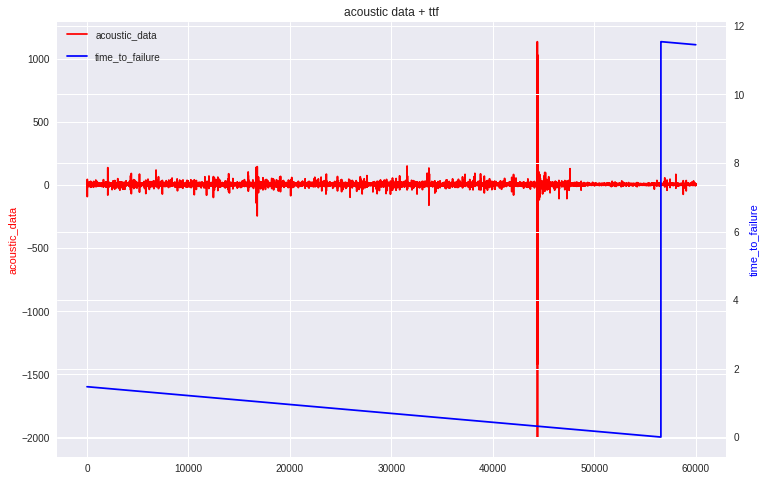

In [10]:
#visualise 1% of saple data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#plotting the sample data
def plot_ad_ttf(train_ad_sample_df,train_ttf_sample_df,title="acoustic data + ttf"):
  fig,ax1 = plt.subplots(figsize=(12,8))
  plt.title(title)
  plt.plot(train_ad_sample_df,color='r')
  ax1.set_ylabel('acoustic_data',color='r')
  plt.legend(['acoustic_data'],loc=(0.01,0.95))
  
  ax2 = ax1.twinx()
  
  plt.plot(train_ttf_sample_df,color='b')
  ax2.set_ylabel('time_to_failure',color='b')
  plt.legend(['time_to_failure'],loc=(0.01,0.9))
  
plot_ad_ttf(train_ad_sample_df,train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

#Feature Engineering

In [0]:
#feature engineering
def gen_features(X):
  strain = []
  strain.append(X.mean())
  strain.append(X.std())
  strain.append(X.min())
  strain.append(X.max())
  strain.append(X.kurtosis())
  strain.append(np.quantile(X,0.01))
  strain.append(np.quantile(X,0.05))
  strain.append(np.quantile(X,0.5))
  strain.append(np.quantile(X,0.95))
  strain.append(np.quantile(X,0.99))
  strain.append(np.abs(X).max())
  strain.append(np.abs(X).mean())
  strain.append(np.abs(X).std())
  strain.append(X.skew())
  
  return pd.Series(strain)

In [0]:
train = pd.read_csv('train.csv',iterator=True,chunksize=150_00,dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
x_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
  ch = gen_features(df['acoustic_data'])
  x_train = x_train.append(ch,ignore_index=True)
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [16]:
x_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,41944.000000,41944.000000,41944.000000,41944.000000,41944.000000,41944.000000,41944.000000,41944.000000,41944.000000,41944.000000,41944.000000,41944.000000,41944.000000,41944.000000
mean,4.519472,5.697077,-51.937035,62.428190,14.921445,-11.819559,-2.522519,4.520539,11.573015,20.912006,63.785071,5.547472,4.870256,0.054051
std,0.297397,9.094914,97.279562,100.010095,17.177569,32.788371,9.860915,0.501115,10.080722,32.371612,107.873633,3.504457,8.301303,0.293193
min,3.260800,2.604655,-5515.000000,13.000000,-0.099967,-1726.020000,-647.000000,3.000000,8.000000,10.000000,13.000000,3.672467,2.357850,-4.224429
25%,4.324000,3.547815,-63.000000,30.000000,3.147374,-14.000000,-3.000000,4.000000,10.000000,13.000000,30.000000,4.870900,3.060805,-0.044086
50%,4.521267,4.574561,-36.000000,46.000000,9.057178,-8.000000,-2.000000,5.000000,11.000000,17.000000,46.000000,5.218567,3.797968,0.024943
75%,4.718533,6.305464,-21.000000,74.000000,20.687733,-4.000000,-1.000000,5.000000,12.000000,23.000000,75.000000,5.753683,5.236108,0.128477
max,5.808400,482.621835,-4.000000,5444.000000,368.303958,-1.000000,1.000000,6.000000,705.050000,1790.000000,5515.000000,212.890067,433.157577,4.530444


#Implement Catboost Model

In [17]:
#model1 catboost
train_pool = Pool(x_train,y_train)
m = CatBoostRegressor(iterations=10000,loss_function='MAE', boosting_type='Ordered')
m.fit(x_train,y_train,silent=True)
m.best_score_

{'learn': {'MAE': 2.353572914382757}}

#Implement Support Vector Machine + Radial Basis Function Kernel

In [0]:
#model2
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)


In [0]:
#model2
parameters = [{'gamma': [0.02, 0.05, 0.1],
              'C': [0.5, 1, 1.5, 2]}]
    

reg1 = GridSearchCV(SVR(kernel='rbf',tol=0.01),parameters,cv=5,scoring='neg_mean_absolute_error')
reg1.fit(x_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(x_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)